In [188]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import time 
import pandas as pd
import itertools
from ast import literal_eval

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels_new
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
#from utils.message_preprocess import message_processing
from utils.prepocess_code_change import parse_json, preprocess_roots, actions2sentence,expand_list,permutate_files
from utils.prepocess_code_change import get_seqlength,plot_hist,get_file_threshold,concat_files_to_sentence
from utils.plot_utils import pie_plot
from utils.embedding_utils import load_embedding

np.random.seed(0)

### Data Preparation

#### processing labels

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']
Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Module Move : 5
Rename : 5
Versioning : 4
Merge : 3
Initialization : 2
Internationalization : 1
Data : 1
Module Add : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


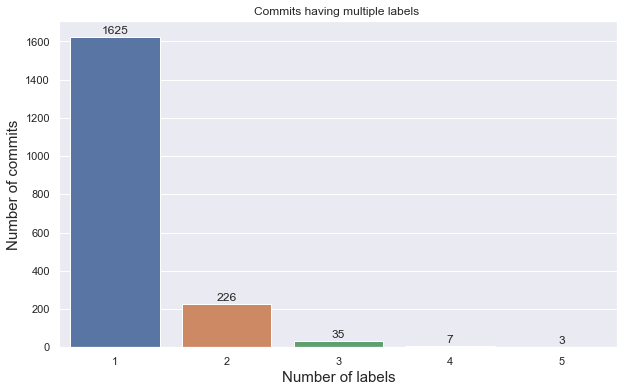

Corrective : 266
Adaptive : 237
Perfective : 1093
Implementation : 330
Non_functional : 70
Other : 34
Corrective : 266
Adaptive : 237
Perfective : 1093
Implementation : 330
1    1616
2     136
0     132
3      10
4       2
dtype: int64


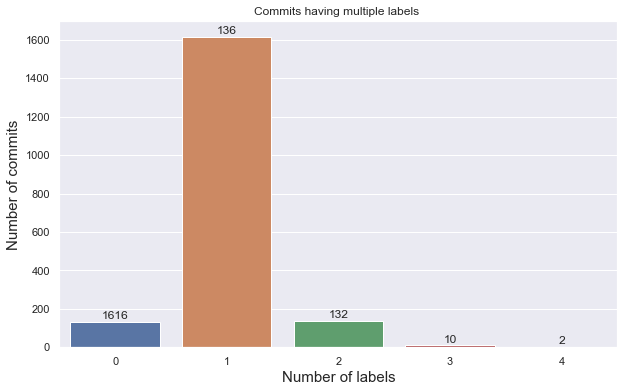

current number of samples: 1896
number of samples after drop:1616


In [232]:
# read data
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

# merge some of categories
new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

# Drop 'Non-functional' and 'Other'
new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

# Drop target col
new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
target_col = ['Adaptive','Perfective','Implementation']

#### Read code change data

In [233]:
# generate file name for search
csha = new_df['Commit ID'].values
files = [c + '.json' for c in csha]
application_name = new_df['project name'].values
files_path = []
for project_name, c in zip(application_name,files):
    files_path.append(project_name + '_' + c)
print(files_path[0])

# get code change data
files = files_path
folder_path = 'D:\\Research\\AllFiles_Research\\'
all_files, csha = parse_json(folder_path, files)

# preprocess_roots
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))
print(len(dic))

# concat action to sentence
training_data = actions2sentence(datas)

apache-avro_2df0775d2f368b326e3ac6442ce4850e3fe62edc.json
472


#### Permutate and get train data

In [234]:
# merge csha and training data to a dataframe
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
print(new_df.shape)

# merge two dataframe and drop some of labels
commits_labels_df = pd.merge(commits_df, new_df, on='Commit ID')

commits_labels_df = expand_list(commits_labels_df)
print(commits_labels_df.shape)

adaptive = commits_labels_df[commits_labels_df['Adaptive'] == 1]
perfective = commits_labels_df[commits_labels_df['Perfective'] == 1]
implementation = commits_labels_df[commits_labels_df['Implementation'] == 1]
perfective = perfective.sample(frac = 0.33, random_state = 0)

print(adaptive.shape)
print(perfective.shape)
print(implementation.shape)

commits_labels_df = pd.concat([adaptive, perfective, implementation], ignore_index = True)

# split dataframe to train and test
msk = np.random.rand(len(commits_labels_df)) < 0.8
train_df = commits_labels_df[msk]
test_df = commits_labels_df[~msk]

print('train_df shape:',train_df.shape)
print('test_df shape:',test_df.shape)

(1389, 29)
(5605, 30)
(1121, 30)
(1165, 30)
(954, 30)
train_df shape: (2563, 30)
test_df shape: (677, 30)


#### Determine File Threshold

<sample training data>:  ['INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_VariableDeclarationStatement_Block INS_EnhancedForStatement_Block']
max length: 643
length threshold 6


C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


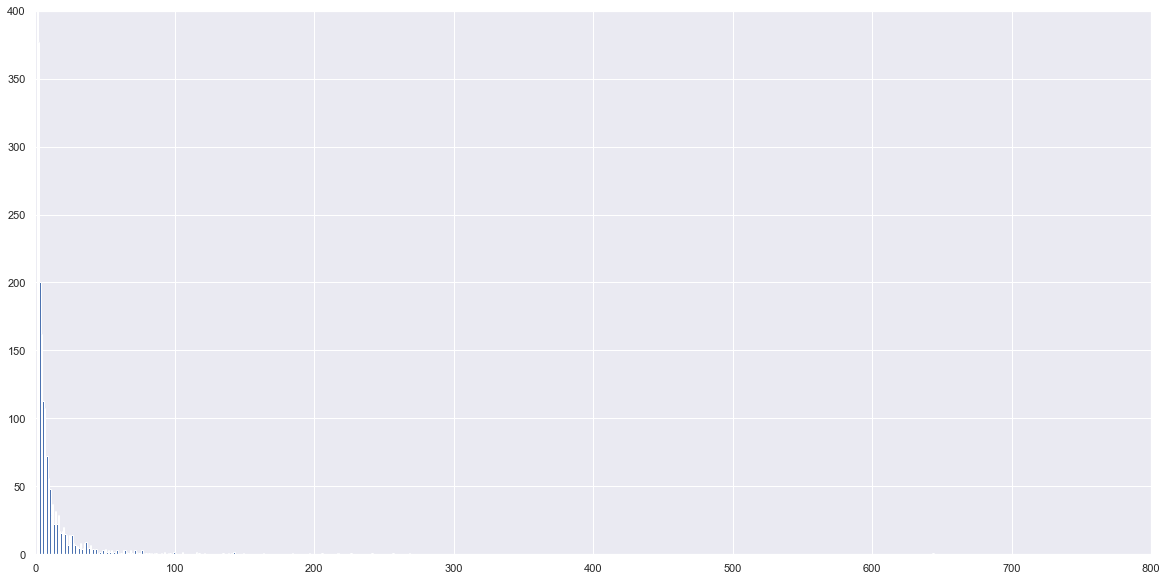

In [235]:
# concat file to sentences
# concat_train_data = concat_files_to_sentence(expanded_train_df["Files"])
# concat_test_data = concat_files_to_sentence(test_df["Files"])
# print(concat_train_data[1])
concat_train_data = train_df['Files']

# plot distribution
max_seqlength, sequence_list = get_seqlength(train_df['Files'])
print("<sample training data>: ", training_data[1])
print('max length: %d'%max_seqlength)
plot_hist(sequence_list)

# getting file threshold
threshold = 0.7
number_of_actions = [len(item.split()) for item in concat_train_data]
length_threshold = get_file_threshold(number_of_actions, threshold)
print("length threshold %d"%length_threshold)

# filter too long commits
train_df['len_seq'] = train_df.apply(lambda row: len(row['Files'].split()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].split()), axis = 1)
train_df = train_df[train_df['len_seq'] <= length_threshold].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] <= length_threshold].reset_index(drop = True)
# print(test_df.columns)

In [236]:
train_df['len_seq'] = train_df.apply(lambda row: len(row['Files'].strip()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].strip()), axis = 1)
train_df = train_df[train_df['len_seq'] != 0].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] != 0].reset_index(drop = True)

####  Tokenize and Pad data and get embedding

In [241]:
# padding data
train_test_split_number = train_df.shape[0]
print(train_df.shape)
df_for_tokenize = pd.concat([train_df,test_df], axis = 0)
print(df_for_tokenize.shape)

#Training 
docs = df_for_tokenize['Files'].values
t = Tokenizer(filters = '', lower=False)
t.fit_on_texts(docs)

sequences = t.texts_to_sequences(docs)
print(sequences[0])

#Pad training data 
padded_seq = pad_sequences(sequences, maxlen=length_threshold+1, padding="post", truncating="post")
print(padded_seq.shape)

vocabulary = t.word_index 
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"
print('length of vocabulary:%d'%len(vocabulary_inv.keys()))

# split train and test set
X_train = padded_seq[0:train_test_split_number]
X_test = padded_seq[train_test_split_number:]

target_col =  ['Adaptive','Perfective','Implementation']
y_train = train_df[target_col].values
y_test = test_df[target_col].values

print(X_train[10, :])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# get embedding
pre_embed = load_embedding("embedding_genism_64_dic.txt")

embedding_weights = dict()
for key in range(0, len(vocabulary_inv.keys())):
    embedding_weights[key] = pre_embed[vocabulary_inv[key]]

# X_train = np.stack([np.stack([pre_embed[vocabulary_inv_train[action]] for action in commit]) for commit in X_train])
# X_test = np.stack([np.stack([pre_embed[vocabulary_inv_test[action]] for action in commit]) for commit in X_test])
# print("x_train static shape:", X_train.shape)
# print("x_test static shape:", X_test.shape)

(1662, 31)
(2092, 31)
[9]
(2092, 7)
length of vocabulary:229
[21  0  0  0  0  0  0]
(1662, 7)
(430, 7)
(1662, 3)
(430, 3)


### CNN for text pytorch

In [242]:
import os
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from model.CNN import CNN_Text
from train_model import train, eval, print_evaluation_scores
from dataloader import CodeChangeDataset, ToTensor

In [243]:
class Args:
    def __init__(self, parameters):
        # model parameters
        self.lr = parameters['lr'] if parameters.get('lr') != None else 0.001
        self.epochs = parameters['epoch'] if parameters.get('epoch') != None else 10
        self.batch_size = parameters['batch_size'] if parameters.get('batch_size') != None else 64
        self.shuffle = parameters['shuffle'] if parameters.get('shuffle') != None else False                     # whether to shuffle data after every epoch
        self.dropout = parameters['dropout'] if parameters.get('dropout') != None else 0.5
        self.max_norm = parameters['l2-norm'] if parameters.get('l2-norm') != None else 3.0                      # l2 norm
        self.embed_dim = parameters['embed_dim'] if parameters.get('embed_dim') != None else 64                 # embedding dimension
        self.embed_num = parameters['embed_num'] if parameters.get('embed_num') != None else 5000               # number of filters for each conv
        self.kernel_num = parameters['kernel_num'] if parameters.get('kernel_num') != None else 10               # number of filters for each conv
        self.kernel_sizes = parameters['kernel_sizes'] if parameters.get('kernel_sizes') != None else [3,4,5]    # list of kernel sizes
        self.class_num = parameters['class_num'] if parameters.get('class_num') != None else 3
        self.pool_size = parameters['pool_size'] if parameters.get('pool_size') != None else 2
        self.static = parameters['static'] if parameters.get('static') != None else True
        self.embed_weights = None
        
        # training precocess parameters
        self.log_interval = parameters['log_interval'] if  parameters.get('log_interval') != None else 1
        self.test_interval = parameters['test_interval'] if  parameters.get('test_interval') != None else 10
        self.save_interval = parameters['save_interval'] if  parameters.get('save_interval') != None else 100
        self.save_dir = parameters['save_dir'] if  parameters.get('save_dir') != None else './'
        self.early_stop = parameters['early_stop'] if  parameters.get('early_stop') != None else 3000
        self.save_best = parameters['save_best'] if  parameters.get('save_best') != None else True
        self.no_cuda = parameters['no_cuda'] if  parameters.get('no_cuda') != None else False            # wether to use gpu
        self.device = parameters['device'] if  parameters.get('device') != None else -1                 # which device to use -1 means cpu
        self.cuda = True

In [244]:
def main():
    # REPRODUCIBILITY
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    
    vocab_size = len(vocabulary_inv.keys())
    
    # Parameters
    parameters = {'class_num':3,
                  'embed_dim':64,
                  'epoch':80, 
                  'batch_size':128, 
                  'device':0,
                  'lr':0.001, 
                  'shuffle':False,
                  'dropout':0.5, 
                  'l2-norm':  3.0, 
                  'embed_num': vocab_size,
                  'kernel_num':400, 
                  'kernel_sizes':[3,4,5],
                  'pool_size':2,
                  'static':True
                 }
    args = Args(parameters)

    # change dir
    args.save_dir = os.path.join(args.save_dir, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    # check gpu avialiable
    args.cuda = (not args.no_cuda) and torch.cuda.is_available()
    print(args.cuda)
    # pretrained embedding weights
    args.embed_weights = torch.from_numpy(np.array([v for v in embedding_weights.values()])).float()
    
    # data loader
    train_data = CodeChangeDataset(X_train, y_train, transform = ToTensor())
    test_data = CodeChangeDataset(X_test, y_test, transform = ToTensor())

    train_dataloader = DataLoader(train_data, batch_size=args.batch_size,shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle = False, num_workers=0)

    # model
    model = CNN_Text(args)
    # if args.snapshot is not None:
    #     print('\nLoading model from {}...'.format(args.snapshot))
    #     cnn.load_state_dict(torch.load(args.snapshot))

    if args.cuda:
        torch.cuda.set_device(args.device)
        model = model.cuda()

    try:
        for epoch in range(args.epochs):
            train_loss, train_acc = train(train_dataloader, model, args, 'CNN')
            val_loss, val_acc = eval(test_dataloader, model, args,'CNN')
            print(f'Epoch: {epoch + 1:02} -- Train Loss: {train_loss:.3f} Train Acc: {train_acc:.2f}%    Val. Loss: {val_loss:3f} Val. Acc: {val_acc:.2f}%')
    
    except KeyboardInterrupt:
        print('\n' + '-' * 89)
        print('Exiting from training early')

if __name__ == '__main__':
    main()

True
Epoch: 01 -- Train Loss: 0.008 Train Acc: 60.00%    Val. Loss: 0.837163 Val. Acc: 70.00%
Epoch: 02 -- Train Loss: 0.006 Train Acc: 69.00%    Val. Loss: 0.653227 Val. Acc: 74.00%
Epoch: 03 -- Train Loss: 0.005 Train Acc: 72.00%    Val. Loss: 0.575346 Val. Acc: 76.00%
Epoch: 04 -- Train Loss: 0.005 Train Acc: 73.00%    Val. Loss: 0.545058 Val. Acc: 76.00%
Epoch: 05 -- Train Loss: 0.004 Train Acc: 74.00%    Val. Loss: 0.542346 Val. Acc: 75.00%
Epoch: 06 -- Train Loss: 0.004 Train Acc: 74.00%    Val. Loss: 0.526511 Val. Acc: 77.00%
Epoch: 07 -- Train Loss: 0.004 Train Acc: 76.00%    Val. Loss: 0.520846 Val. Acc: 76.00%
Epoch: 08 -- Train Loss: 0.004 Train Acc: 76.00%    Val. Loss: 0.517302 Val. Acc: 77.00%
Epoch: 09 -- Train Loss: 0.004 Train Acc: 78.00%    Val. Loss: 0.515917 Val. Acc: 76.00%
Epoch: 10 -- Train Loss: 0.004 Train Acc: 77.00%    Val. Loss: 0.516236 Val. Acc: 76.00%
Epoch: 11 -- Train Loss: 0.004 Train Acc: 79.00%    Val. Loss: 0.519658 Val. Acc: 77.00%
Epoch: 12 -- Tra

### RNN for text classification

In [185]:
import os
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from model.GRU import SimpleGRU
from train_model import train, eval, print_evaluation_scores
from dataloader import CodeChangeDataset, ToTensor

In [186]:
class Args:
     def __init__(self):
        self.vocab_size = None
        self.embedding_dim = None
        self.n_hidden = None
        self.n_out = None
        self.num_layers = None
        self.lr = None
        self.batch_size = None
        self.cude = None
        self.epochs = None
        self.embed_weights = None
        self.device = None

In [187]:
def main():
    # REPRODUCIBILITY
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    
    vocab_size = len(vocabulary_inv.keys())
    args = Args()
    
    # Parameters
    args.vocab_size = vocab_size 
    args.embedding_dim = 64 
    args.n_hidden = 300 
    args.n_out = 3
    args.num_layers = 1
    args.lr = 0.001
    args.batch_size = 256
    args.cuda = True
    args.epochs = 50
    args.device = 0
    args.weights = torch.from_numpy(np.array([v for v in embedding_weights.values()])).float()
    
    # data loader
    train_data = CodeChangeDataset(X_train, y_train, transform = ToTensor())
    test_data = CodeChangeDataset(X_test, y_test, transform = ToTensor())

    train_dataloader = DataLoader(train_data, batch_size=args.batch_size,shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle = False, num_workers=0)

    # model
    model = SimpleGRU(args)
    
    if args.cuda:
        torch.cuda.set_device(args.device)
        model = model.cuda()

    try:
        for epoch in range(args.epochs):
            train_loss, train_acc = train(train_dataloader, model, args, 'GRU')
            val_loss, val_acc = eval(test_dataloader, model, args,'GRU')
            print(f'Epoch: {epoch + 1:02} -- Train Loss: {train_loss:.3f} Train Acc: {train_acc:.2f}%    Val. Loss: {val_loss:3f} Val. Acc: {val_acc:.2f}%')
    
    except KeyboardInterrupt:
        print('\n' + '-' * 89)
        print('Exiting from training early')

if __name__ == '__main__':
    main()     

Epoch: 01 -- Train Loss: 0.004 Train Acc: 58.00%    Val. Loss: 0.863446 Val. Acc: 70.00%
Epoch: 02 -- Train Loss: 0.003 Train Acc: 68.00%    Val. Loss: 0.700835 Val. Acc: 72.00%
Epoch: 03 -- Train Loss: 0.003 Train Acc: 70.00%    Val. Loss: 0.622568 Val. Acc: 73.00%
Epoch: 04 -- Train Loss: 0.003 Train Acc: 70.00%    Val. Loss: 0.579706 Val. Acc: 75.00%
Epoch: 05 -- Train Loss: 0.002 Train Acc: 74.00%    Val. Loss: 0.565998 Val. Acc: 76.00%
Epoch: 06 -- Train Loss: 0.002 Train Acc: 75.00%    Val. Loss: 0.557463 Val. Acc: 75.00%
Epoch: 07 -- Train Loss: 0.002 Train Acc: 76.00%    Val. Loss: 0.550187 Val. Acc: 76.00%
Epoch: 08 -- Train Loss: 0.002 Train Acc: 76.00%    Val. Loss: 0.548845 Val. Acc: 73.00%
Epoch: 09 -- Train Loss: 0.002 Train Acc: 77.00%    Val. Loss: 0.527469 Val. Acc: 77.00%
Epoch: 10 -- Train Loss: 0.002 Train Acc: 79.00%    Val. Loss: 0.551145 Val. Acc: 70.00%
Epoch: 11 -- Train Loss: 0.002 Train Acc: 79.00%    Val. Loss: 0.536250 Val. Acc: 73.00%
Epoch: 12 -- Train Lo